<a href="https://colab.research.google.com/github/jobellet/fast_and_rich_decoding_in_VLPFC/blob/main/monkeyH_PFC_VS_PPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import urllib.request
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy import stats
import numpy.matlib
from skimage.measure import label
import seaborn as sb
from tqdm import tqdm


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = "Arial"
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# functions for loading data
def get_monkeyH_dfs():
    try:
        dfPFC = pd.read_pickle('monkeyH.pkl')
        try:
            dfPPC = pd.read_pickle('monkeyH_PPC.pkl')
        except:
            !pip3 install pickle5
            import pickle5 as pickle
            with open('monkeyH_PPC.pkl', "rb") as fh:
                dfPPC = pickle.load(fh)
    except:
        link_to_monkeyH_PFC_data = 'https://ndownloader.figshare.com/files/27946635?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyH_PFC_data,'monkeyH.pkl')
        dfPFC = pd.read_pickle('monkeyH.pkl')
        
        link_to_monkeyH_PPC_data = 'https://ndownloader.figshare.com/files/28224414?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyH_PPC_data,'monkeyH_PPC.pkl')
        
        try:
            dfPPC = pd.read_pickle('monkeyH_PPC.pkl')
        except:
            !pip3 install pickle5
            import pickle5 as pickle
            with open('monkeyH_PPC.pkl', "rb") as fh:
                dfPPC = pickle.load(fh)
            
    return dfPFC,dfPPC

# functions for PSTH
def getSpikemat(spiketimes,mint=-.1,maxt=.4):
    '''
    Bin spiketimes at 1 kHz, single stimuli / trials
    '''
    t_total = int((maxt-mint)*1000) # total time bins
    nch = len(spiketimes)
    spikemat = np.zeros((nch,t_total)).astype(bool)
    for ch in range(nch):
        tms = np.round(spiketimes[ch]*1000).astype(int) - 1 #0-indexing
        
        tms = tms[(tms>=mint*1000) & (tms<maxt*1000)] - int(mint*1000)
        if len(tms)>0:
            spikemat[ch,tms] = 1
   
    return spikemat

def gen_time_bin(binsize,overlap,mint=-.1,maxt=.4):
    all_bins = []
    for i in range(int(binsize/overlap)):
        all_bins.append(np.arange(mint,maxt,binsize)+overlap*i)
    time_bins = np.sort(np.concatenate(all_bins)).astype(int)
    return(time_bins)

def rate_binning(spike_times,time_bins,binsize):
    time_bins = time_bins/1000 # convert in s
    binsize = binsize/1000 # convert in s
    average = np.zeros((len(spike_times),len(time_bins)))
    for i,t in enumerate(time_bins):
        
        for chan in range(len(spike_times)):
            include = (spike_times[chan]>t) & (spike_times[chan]<(t+binsize))
            average[chan,i] = sum(include)/binsize
    return(average)

# function for cluster correction for multiple comparisons
def cluster_perm(real_data,permutations,pval_roi_threshold,pval_threshold):
    
    mean_perm = np.mean(permutations,axis = 0)
    std_perm = np.std(permutations,axis = 0)
    tval = (real_data-mean_perm)/std_perm
    pval = np.mean(np.matlib.repmat(real_data,permutations.shape[0],1) <= permutations,axis = 0)
    clusters = label(pval<pval_roi_threshold)
    sum_tvals = []
    significant_points = np.zeros_like(real_data).astype(bool)
    for i in range(max(clusters)):
        sum_tvals.append(sum(tval[clusters == (i+1)]))
    
    max_sum_tvals_perm = np.zeros(permutations.shape[0])
    for i in range(permutations.shape[0]):
        real_data_perm = permutations[i,:]
        tvalperm = (real_data_perm-mean_perm)/std_perm
        pvalperm = np.mean(np.matlib.repmat(real_data_perm,permutations.shape[0]-1,1) <= np.delete(permutations,i,axis = 0),axis = 0)
        clusters_perm = label(pvalperm<pval_roi_threshold)
        sum_tvals_perm = []
        for j in range(max(clusters_perm)):
            sum_tvals_perm.append(sum(tvalperm[clusters_perm == (j+1)]))
        
        if len(sum_tvals_perm)>0:
            max_sum_tvals_perm[i] = np.max(sum_tvals_perm)
    for i in range(max(clusters)):
        if np.mean(sum_tvals[i]<max_sum_tvals_perm)<pval_threshold:
            significant_points[clusters == (i+1)] = True
    return(significant_points)

# global parameters
nch = 96 # number of channels in the Utah array
sf = 30000; # sampling frequency
tmin = -100 #ms, time before each stim
tmax = 600 #ms, time after each stim

# parameters for binning and normalization
binsize = 50 #ms
overlap = 25 #ms
time_bins = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
dfPFC,dfPPC = get_monkeyH_dfs()


## Obtain normalized firing rate from spike time 

In [21]:
compute_this_step = False # 


def get_monkeyH_firing_rate():
    try:
        Rb = np.load('monkeyH_PFC_raw_firing_rate.npy')
        Rc = np.load('monkeyH_PFC_normalized_firing_rate.npy')
        
    except:
        link_to_monkeyH_raw_firing_rate_PFC = 'https://ndownloader.figshare.com/files/28205322?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyH_raw_firing_rate_PFC,'monkeyH_PFC_raw_firing_rate.npy')
        
        
        link_to_monkeyH_nomalized_firing_rate_PFC = 'https://ndownloader.figshare.com/files/28205325?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyH_nomalized_firing_rate_PFC,'monkeyH_PFC_normalized_firing_rate.npy')
        Rb = np.load('monkeyH_PFC_raw_firing_rate.npy')
        Rc = np.load('monkeyH_PFC_normalized_firing_rate.npy')
    
    try:
        PPC_Rb = np.load('monkeyH_PPC_raw_firing_rate.npy')
        PPC_Rc = np.load('monkeyH_PPC_normalized_firing_rate.npy')
    except:
        link_to_monkeyH_raw_firing_rate_PPC = 'https://ndownloader.figshare.com/files/28019382?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyH_raw_firing_rate_PPC,'monkeyH_PPC_raw_firing_rate.npy')
        
        link_to_monkeyH_nomalized_firing_rate_PPC = 'https://ndownloader.figshare.com/files/28019376?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyH_nomalized_firing_rate_PPC,'monkeyH_PPC_normalized_firing_rate.npy')
        PPC_Rb = np.load('monkeyH_PPC_raw_firing_rate.npy')
        PPC_Rc = np.load('monkeyH_PPC_normalized_firing_rate.npy')
    return Rb,Rc,PPC_Rb,PPC_Rc

if compute_this_step:
    # create PFC PSTH
    ntr = len(dfPFC) # number of stimuli presentations

    nbins = len(time_bins)
    Rb = np.zeros((ntr,nch,nbins)) # this will store the firing rate
    Rc = np.zeros((ntr,nch,nbins)) # this will store the normalized firing rate
    for tr in tqdm(range(ntr)): # loop through every stimuli presentations
        Rb[tr,:] = rate_binning(dfPFC['Spikes'].iloc[tr],time_bins,binsize)
        
    ## center each channel
    for sesID in np.unique(np.array(dfPFC.sesID)):
        for ch in range(nch):
            Rc[df.sesID == sesID,ch,:] = (Rb[df.sesID == sesID,ch,:] - np.mean(Rb[df.sesID == sesID,ch,:])) / (np.std(Rb[df.sesID == sesID,ch,:]) + 10e-6) # center each channel for each session independentl
    np.save('monkeyH_PFC_raw_firing_rate.npy',Rb)
    np.save('monkeyH_PFC_normalized_firing_rate.npy',Rc)
    
    # create PPC PSTH
    ntr = len(dfPPC) # number of stimuli presentations

    nbins = len(time_bins)
    PPC_Rb = np.zeros((ntr,nch,nbins)) # this will store the firing rate
    PPC_Rc = np.zeros((ntr,nch,nbins)) # this will store the normalized firing rate
    for tr in tqdm(range(ntr)): # loop through every stimuli presentations
        PPC_Rb[tr,:] = rate_binning(dfPPC['PPC_Spikes'].iloc[tr],time_bins,binsize)
        
    ## center each channel
    for sesID in np.unique(np.array(df.sesID)):
        for ch in range(nch):
            PPC_Rc[dfPPC.sesID == sesID,ch,:] = (PPC_Rb[dfPPC.sesID == sesID,ch,:] - np.mean(PPC_Rb[dfPPC.sesID == sesID,ch,:])) / (np.std(PPC_Rb[dfPPC.sesID == sesID,ch,:]) + 10e-6) # center each channel for each session independentl
    np.save('monkeyH_PPC_raw_firing_rate.npy',PPC_Rb)
    np.save('monkeyH_PPC_normalized_firing_rate.npy',PPC_Rc)
else:
    Rb,Rc,PPC_Rb,PPC_Rc = get_monkeyH_firing_rate()

# Find visually responsive channels in PPC

In [22]:
def get_usefull_channels(df,Rb,t):
    
    baseline = np.mean(Rb[:,:,0],axis =0)
    live_channels = baseline>1
    
    all_amp = np.zeros((96,len(t)))

    stimuli = np.unique(np.array(df.StimID).astype(int));
    
    outstat= np.zeros(96).astype(int)
    for i in range(96):
        if live_channels[i]:
            temp = np.zeros((18,len(t)))
            variation = np.zeros((18,2))
            for stm in stimuli:
                indx = np.where(df.StimID == stm)
                average_rate = np.mean(np.squeeze(Rb[indx,i,:]),axis = 0)-baseline[i]
                temp[stm,:] = abs(average_rate)
                
                variation[stm,0]=abs(np.mean(average_rate[(t>t[1]) & (t<=50)]))
                variation[stm,1]=abs(np.mean(average_rate[(t>=100) & (t<=200)]))
            outstat[i] = stats.ttest_rel(variation[:,0],variation[:,1])[0]<-1.9
        else:
            outstat[i] = 0
    
    return(outstat)

In [23]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 
outPFC = get_usefull_channels(dfPFC,Rb,t)
print(sum(outPFC))
outPPC = get_usefull_channels(dfPPC,PPC_Rb,t)
print(sum(outPPC))

20
25


In [24]:
maximal_chan_num = np.min((sum(outPFC),sum(outPPC)))
left_out = np.round(.1*maximal_chan_num).astype(int)
RSVP_PPC = (np.array(dfPPC.TrialID)==100)  # select only stimuli presentation being followed by an other stimulus 100 ms after the onset
RSVP_PPC = RSVP_PPC & np.concatenate(([False],RSVP_PPC[:-1])) # select only stimuli presentation being preceded by an other stimulus 100 ms before the onset

RSVP_PFC = np.array(dfPFC.duration >= 0.040) & np.array(dfPFC.duration <= 0.060) & np.array(dfPFC.TrialID < 110)
RSVP_PFC = RSVP_PFC & np.concatenate(([False],RSVP_PFC[:-1]))

single_stim_PPC = np.array(dfPPC.TrialID)>500
single_stim_PPC = single_stim_PPC & np.concatenate(([False],single_stim_PPC[:-1]))

single_stim_PFC = np.array(dfPFC.TrialID)>390
single_stim_PFC = single_stim_PFC & np.concatenate(([False],single_stim_PFC[:-1]))
maximal_training_stims = np.min((sum(RSVP_PPC),sum(RSVP_PFC)))
maximal_training_stims_single_stim = np.min((sum(single_stim_PPC),sum(single_stim_PFC)))

# Estimate difference in accuracy between PFC and PPC for stimuli in isolation/slow pace

In [ ]:
nstim = len(np.unique(dfPPC.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
nperm = 50;
K = 10 # number of training folds
# index

accuracy_PPC = np.zeros((nperm,len(t)))


nbins = len(t) # number of time bins
        
if True:#reproduce_all:
    
        
    for perm in tqdm(range(nperm)):
        selected_chan = np.where(outPPC.astype(bool))[0];
        selected_chan = selected_chan[np.random.permutation(len(selected_chan))][:maximal_chan_num-left_out]
        
        temp = np.where(single_stim_PPC)[0]  # select only stimuli presentation being followed by an other stimulus 100 ms after the onset
        temp = temp[np.random.permutation(len(temp))][:maximal_training_stims_single_stim]
        training_stims = np.zeros_like(single_stim_PPC).astype(bool)
        training_stims[temp] = True

        X = PPC_Rc[:,selected_chan,:] # The firing rate
        Y = np.array(dfPPC.StimID).astype(int)
        ntr = X.shape[0]
        ntest = int(ntr/K)
        shuffle = np.random.permutation(ntr)# permutation of every trial
        Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
        Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
        for k in range(K):
            testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
            if k == K-1:
                testind = shuffle[k*ntest:] 
            Ytest = Y[testind].astype(int)
            trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
            trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
            Xtrain = X[trainind,:]
            Ytrain = Y[trainind]

            for b in range(nbins):
                model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
                Coef[:,:,b,k] = model.coef_
                Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
        all_single_stim = np.zeros((18,len(t)))
        for n in stims:
            # in single_stim
            isolated = np.argmax(Proba[single_stim_PPC & (dfPPC.StimID == n) & training_stims,:],axis = 1) == n
            all_single_stim[n,:] = np.mean(isolated, axis = 0)
        accuracy_PPC[perm,:] = np.mean(all_single_stim,axis = 0)

100%|██████████| 50/50 [04:33<00:00,  5.48s/it]


In [ ]:
nstim = len(np.unique(dfPFC.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
nperm = 50;
K = 10 # number of training folds
# index

accuracy_PFC = np.zeros((nperm,len(t)))


nbins = len(t) # number of time bins
        
if True:#reproduce_all:
    
        
    for perm in tqdm(range(nperm)):
        selected_chan = np.where(outPFC.astype(bool))[0];
        selected_chan = selected_chan[np.random.permutation(len(selected_chan))][:maximal_chan_num-left_out]
        
        temp = np.where(single_stim_PFC)[0]  # select only stimuli presentation being followed by an other stimulus 100 ms after the onset
        temp = temp[np.random.permutation(len(temp))][:maximal_training_stims_single_stim]
        training_stims = np.zeros_like(single_stim_PFC).astype(bool)
        training_stims[temp] = True

        X = Rc[:,selected_chan,:] # The firing rate
        Y = np.array(dfPFC.StimID).astype(int)
        ntr = X.shape[0]
        ntest = int(ntr/K)
        shuffle = np.random.permutation(ntr)# permutation of every trial
        Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
        Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
        for k in range(K):
            testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
            if k == K-1:
                testind = shuffle[k*ntest:] 
            Ytest = Y[testind].astype(int)
            trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
            trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
            Xtrain = X[trainind,:]
            Ytrain = Y[trainind]

            for b in range(nbins):
                model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
                Coef[:,:,b,k] = model.coef_
                Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
        all_single_stim = np.zeros((18,len(t)))
        for n in stims:
            # in single_stim
            isolated = np.argmax(Proba[single_stim_PFC & (dfPFC.StimID == n) & training_stims,:],axis = 1) == n
            all_single_stim[n,:] = np.mean(isolated, axis = 0)
        accuracy_PFC[perm,:] = np.mean(all_single_stim,axis = 0)

100%|██████████| 50/50 [08:24<00:00, 10.10s/it]


## Figure S5 C

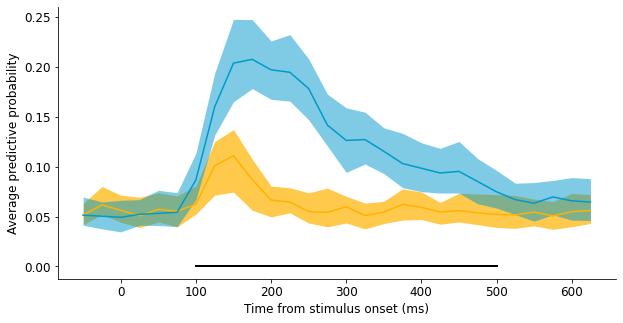

In [ ]:
nperm = 2000
real_diff = accuracy_PPC-accuracy_PFC
permutdiff = np.zeros((nperm,real_diff.shape[1]))
for i in range(nperm):
    permutdiff[i,:] = abs(np.mean(np.matlib.repmat(np.sign(np.random.rand(real_diff.shape[0])-.5),real_diff.shape[1],1).transpose()*real_diff))
sigpoints = cluster_perm(abs(np.mean(real_diff,axis = 0)),permutdiff,.001,.001)

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50
fig,ax = plt.subplots(1,1,figsize = (10,5))

high_bound = np.sort(accuracy_PPC,axis = 0)[49,:]
low_bound = np.sort(accuracy_PPC,axis = 0)[1,:]
ax.fill_between(t,high_bound,low_bound,alpha= 0.7,linewidth = 0,color = [1,0.7,0])
ax.plot(t,np.mean(accuracy_PPC, axis = 0),color = [1,0.7,0])

high_bound = np.sort(accuracy_PFC,axis = 0)[49,:]
low_bound = np.sort(accuracy_PFC,axis = 0)[1,:]
ax.fill_between(t,high_bound,low_bound,alpha= 0.5,linewidth = 0,color = [0,0.6,0.8])
ax.plot(t,np.mean(accuracy_PFC, axis = 0),color = [0,0.6,0.8])

clusters = label(sigpoints)
for k in np.arange(1,max(clusters)+1):
    ax.plot(t[clusters==k],np.ones(sum(clusters==k))*0, color = 'k',linewidth = 2) 

ax.set_xlabel('Time from stimulus onset (ms)')
ax.set_ylabel('Decoding accuracy')
sb.despine()
fig.savefig('monkeyH_PFC_VS_PPC_isolated.pdf')

# Estimate difference in accuracy between PFC and PPC for stimuli in RSVP sequences

In [ ]:
nstim = len(np.unique(dfPPC.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
nperm = 50;
K = 10 # number of training folds
# index

accuracy_PPC = np.zeros((nperm,len(t)))


nbins = len(t) # number of time bins
        
if True:#reproduce_all:
    
        
    for perm in tqdm(range(nperm)):
        selected_chan = np.where(outPPC.astype(bool))[0];
        selected_chan = selected_chan[np.random.permutation(len(selected_chan))][:maximal_chan_num-left_out]
        
        temp = np.where(RSVP_PPC)[0]  # select only stimuli presentation being followed by an other stimulus 100 ms after the onset
        temp = temp[np.random.permutation(len(temp))][:maximal_training_stims]
        training_stims = np.zeros_like(RSVP_PPC).astype(bool)
        training_stims[temp] = True

        X = PPC_Rc[:,selected_chan,:] # The firing rate
        Y = np.array(dfPPC.StimID).astype(int)
        ntr = X.shape[0]
        ntest = int(ntr/K)
        shuffle = np.random.permutation(ntr)# permutation of every trial
        Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
        Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
        for k in range(K):
            testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
            if k == K-1:
                testind = shuffle[k*ntest:] 
            Ytest = Y[testind].astype(int)
            trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
            trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
            Xtrain = X[trainind,:]
            Ytrain = Y[trainind]

            for b in range(nbins):
                model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
                Coef[:,:,b,k] = model.coef_
                Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
        all_RSVP = np.zeros((18,len(t)))
        for n in stims:
            # in RSVP
            hundreds = np.argmax(Proba[RSVP_PPC & (dfPPC.StimID == n) & training_stims,:],axis = 1) == n
            all_RSVP[n,:] = np.mean(hundreds, axis = 0)
        accuracy_PPC[perm,:] = np.mean(all_RSVP,axis = 0)

100%|██████████| 50/50 [11:46<00:00, 14.13s/it]


In [ ]:
nstim = len(np.unique(dfPFC.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
nperm = 50;
K = 10 # number of training folds
# index

accuracy_PFC = np.zeros((nperm,len(t)))


nbins = len(t) # number of time bins
        
if True:#reproduce_all:
    
        
    for perm in tqdm(range(nperm)):
        selected_chan = np.where(outPFC.astype(bool))[0];
        selected_chan = selected_chan[np.random.permutation(len(selected_chan))][:maximal_chan_num-left_out]
        
        temp = np.where(RSVP_PFC)[0]  # select only stimuli presentation being followed by an other stimulus 100 ms after the onset
        temp = temp[np.random.permutation(len(temp))][:maximal_training_stims]
        training_stims = np.zeros_like(RSVP_PFC).astype(bool)
        training_stims[temp] = True

        X = Rc[:,selected_chan,:] # The firing rate
        Y = np.array(dfPFC.StimID).astype(int)
        ntr = X.shape[0]
        ntest = int(ntr/K)
        shuffle = np.random.permutation(ntr)# permutation of every trial
        Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
        Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
        for k in range(K):
            testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
            if k == K-1:
                testind = shuffle[k*ntest:] 
            Ytest = Y[testind].astype(int)
            trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
            trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
            Xtrain = X[trainind,:]
            Ytrain = Y[trainind]

            for b in range(nbins):
                model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
                Coef[:,:,b,k] = model.coef_
                Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
        all_RSVP = np.zeros((18,len(t)))
        for n in stims:
            # in RSVP
            hundreds = np.argmax(Proba[RSVP_PFC & (dfPFC.StimID == n) & training_stims,:],axis = 1) == n
            all_RSVP[n,:] = np.mean(hundreds, axis = 0)
        accuracy_PFC[perm,:] = np.mean(all_RSVP,axis = 0)

100%|██████████| 50/50 [16:21<00:00, 19.63s/it]


## Figure S5 D

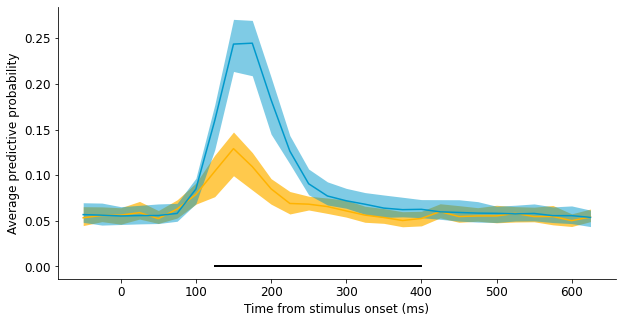

In [ ]:
nperm = 2000
real_diff = accuracy_PPC-accuracy_PFC
permutdiff = np.zeros((nperm,real_diff.shape[1]))
for i in range(nperm):
    permutdiff[i,:] = abs(np.mean(np.matlib.repmat(np.sign(np.random.rand(real_diff.shape[0])-.5),real_diff.shape[1],1).transpose()*real_diff))
sigpoints = cluster_perm(abs(np.mean(real_diff,axis = 0)),permutdiff,.001,.001)

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50
fig,ax = plt.subplots(1,1,figsize = (10,5))

high_bound = np.sort(accuracy_PPC,axis = 0)[49,:]
low_bound = np.sort(accuracy_PPC,axis = 0)[1,:]
ax.fill_between(t,high_bound,low_bound,alpha= 0.7,linewidth = 0,color = [1,0.7,0])
ax.plot(t,np.mean(accuracy_PPC, axis = 0),color = [1,0.7,0])

high_bound = np.sort(accuracy_PFC,axis = 0)[49,:]
low_bound = np.sort(accuracy_PFC,axis = 0)[1,:]
ax.fill_between(t,high_bound,low_bound,alpha= 0.5,linewidth = 0,color = [0,0.6,0.8])
ax.plot(t,np.mean(accuracy_PFC, axis = 0),color = [0,0.6,0.8])

clusters = label(sigpoints)
for k in np.arange(1,max(clusters)+1):
    ax.plot(t[clusters==k],np.ones(sum(clusters==k))*0, color = 'k',linewidth = 2) 

ax.set_xlabel('Time from stimulus onset (ms)')
ax.set_ylabel('Decoding accuracy')
sb.despine()
fig.savefig('monkeyH_PFC_VS_PPC_RSVP.pdf')